# Activations et initialisations


Dans ce cours, nous allons reprendre le modèle Fully Connected présenté dans le cours 5 sur les NLP. Nous allons étudier le comportement des activations tout au long du réseau lors de son initialisation. Ce cours s'inspire du cours d'Andrej Karpathy, intitulé [Building makemore Part 3: Activations & Gradients, BatchNorm](https://www.youtube.com/watch?v=P6sfmUTpUmc&t=3892s&ab_channel=AndrejKarpathy).


Les réseaux de neurones présentent plusieurs avantages :
- Ils sont très flexibles et peuvent résoudre de nombreux problèmes.
- Ils sont assez simples à implémenter.

Cependant, il est souvent complexe de les optimiser, surtout lorsqu'il s'agit de réseaux profonds.


## Reprise du code


Nous reprenons le code du [notebook 3 du cours 5 sur les NLP](../05_NLP/03_RéseauFullyConnected.ipynb).


In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
words = open('../05_NLP/prenoms.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

Pour des raisons pédagogiques, nous n'utiliserons pas le dataset et le dataloader de PyTorch. Nous évaluerons le *loss* au début de l'entraînement après le premier *batch*. Globalement, cela fonctionne de la même manière, sauf que nous prenons un *batch* aléatoire à chaque itération au lieu de parcourir l'ensemble du dataset à chaque *epoch*.


In [3]:
block_size = 3 # Contexte

def build_dataset(words):  
  X, Y = [], []
  
  for w in words:
    context = [0] * block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      context = context[1:] + [ix] 

  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape, Y.shape)
  return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,  Ytr  = build_dataset(words[:n1])     # 80%
Xdev, Ydev = build_dataset(words[n1:n2])   # 10%
Xte,  Yte  = build_dataset(words[n2:])     # 10%

torch.Size([180834, 3]) torch.Size([180834])
torch.Size([22852, 3]) torch.Size([22852])
torch.Size([22639, 3]) torch.Size([22639])


In [4]:
embed_dim=10 # Dimension de l'embedding de C
hidden_dim=200 # Dimension de la couche cachée

C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))
b1 = torch.randn(hidden_dim)
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [5]:
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):
  # Permet de construire un mini-batch
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  
  # Forward
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 

  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  # Retropropagation
  for p in parameters:
    p.grad = None
  
  loss.backward()
  # Mise à jour des paramètres
  lr = 0.1 if i < 100000 else 0.01 # On descend le learning rate d'un facteur 10 après 100000 itérations
  for p in parameters:
    p.data += -lr * p.grad

  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 21.9772
  10000/ 200000: 2.9991
  20000/ 200000: 2.5258
  30000/ 200000: 1.9657
  40000/ 200000: 2.4326
  50000/ 200000: 1.7670
  60000/ 200000: 2.1324
  70000/ 200000: 2.4160
  80000/ 200000: 2.2237
  90000/ 200000: 2.3905
 100000/ 200000: 1.9304
 110000/ 200000: 2.1710
 120000/ 200000: 2.3444
 130000/ 200000: 2.0970
 140000/ 200000: 1.8623
 150000/ 200000: 1.9792
 160000/ 200000: 2.4602
 170000/ 200000: 2.0968
 180000/ 200000: 2.0466
 190000/ 200000: 2.3746


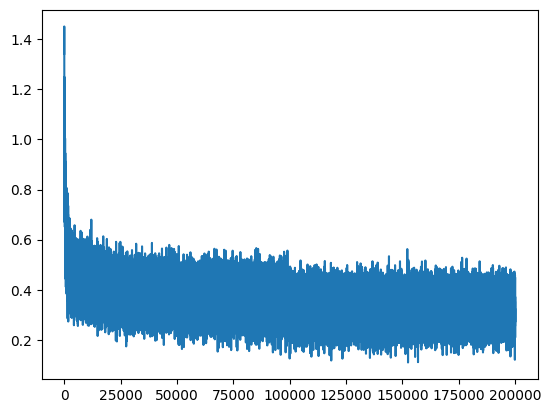

In [6]:
plt.plot(lossi)

Il y a beaucoup de "bruit" car nous calculons le *loss* à chaque fois sur des petits *batchs* par rapport à l'ensemble des données d'entraînement.


## Loss anormalement élevé à l'initialisation


L'entraînement se déroule correctement. Cependant, on remarque quelque chose d'étrange : le *loss* au début de l'entraînement est anormalement élevé. On s'attendrait à obtenir une valeur correspondant à un cas où chaque lettre a une probabilité uniforme d'apparition (soit $\frac{1}{46}$).

Dans ce cas, le *negative log likelihood* serait :
$-ln(\frac{1}{46})=3.83$

Il serait donc logique d'obtenir une valeur de cet ordre lors du premier calcul du *loss*.


### Petit exemple illustrant le problème


Pour comprendre ce qui se passe, utilisons un petit exemple et observons les valeurs de *loss* en fonction de l'initialisation. Imaginons que tous les poids dans *logits* sont initialisés à 0. Dans ce cas, on obtiendrait des probabilités uniformes.


In [7]:
logits=torch.tensor([0.0,0.0,0.0,0.0])
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2500, 0.2500, 0.2500, 0.2500]), tensor(1.3863))

Cependant, il n'est pas conseillé d'initialiser les poids d'un réseau de neurones à 0. Nous avons utilisé une initialisation aléatoire basée sur une gaussienne centrée réduite.


In [8]:
logits=torch.randn(4)
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.3143, 0.0607, 0.3071, 0.3178]), tensor(2.8012))

On voit rapidement le problème : l'aléatoire de la gaussienne fait pencher la balance d'un côté ou de l'autre (vous pouvez lancer plusieurs fois le code précédent pour vous en assurer).

Alors, que peut-on faire ? Il suffit de multiplier notre vecteur *logit* par une petite valeur pour diminuer la valeur initiale des poids et rendre le *softmax* plus uniforme.


In [9]:
logits=torch.randn(4)*0.01
probs=torch.softmax(logits,dim=0)
loss= -probs[1].log()
probs,loss

(tensor([0.2489, 0.2523, 0.2495, 0.2493]), tensor(1.3772))

On obtient, à peu de choses près, le même *loss* que pour des probabilités uniformes.

**Note** : En revanche, on peut initialiser la valeur du biais à zéro, car cela n'a pas de sens d'avoir un biais positif ou négatif à l'initialisation.


### Entraînement avec l'ajustement de l'initialisation


Reprenons le code précédent, mais avec les nouvelles valeurs d'initialisation.


In [10]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim))*0.01 # On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46))*0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [11]:
lossi = []

for i in range(max_steps):
  ix = torch.randint(0, Xtr.shape[0], (batch_size,))
  Xb, Yb = Xtr[ix], Ytr[ix] 
  emb = C[Xb] 
  embcat = emb.view(emb.shape[0], -1)
  hpreact = embcat @ W1 + b1 
  h = torch.tanh(hpreact) 
  logits = h @ W2 + b2 
  loss = F.cross_entropy(logits, Yb)
  
  for p in parameters:
    p.grad = None
  loss.backward()
  lr = 0.1 if i < 100000 else 0.01 
  for p in parameters:
    p.data += -lr * p.grad
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.8304
  10000/ 200000: 2.4283
  20000/ 200000: 2.0651
  30000/ 200000: 2.1124
  40000/ 200000: 2.3158
  50000/ 200000: 2.2752
  60000/ 200000: 2.1887
  70000/ 200000: 2.1783
  80000/ 200000: 1.8120
  90000/ 200000: 2.3178
 100000/ 200000: 2.0973
 110000/ 200000: 1.8992
 120000/ 200000: 1.6917
 130000/ 200000: 2.2747
 140000/ 200000: 1.8054
 150000/ 200000: 2.3569
 160000/ 200000: 2.4231
 170000/ 200000: 2.0711
 180000/ 200000: 2.1379
 190000/ 200000: 1.8419


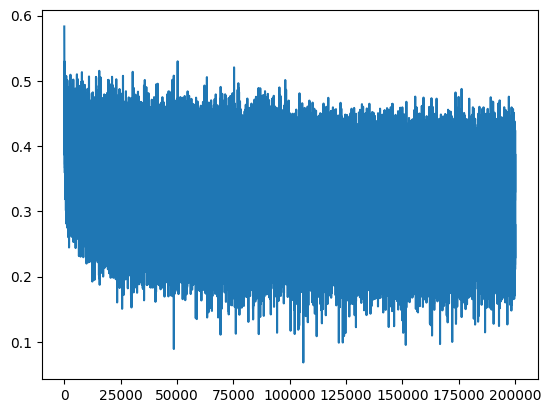

In [12]:
plt.plot(lossi)

Nous avons maintenant une courbe de *loss* qui ne commence pas à une valeur aberrante, ce qui accélère l'optimisation.


## Autre problème


On peut penser qu'un *loss* élevé n'est pas forcément un problème. Cependant, une mauvaise initialisation des poids peut poser d'autres problèmes.

Considérons la première itération de l'entraînement avec des valeurs initialisées sans le facteur 0.01.


In [13]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) 
b1 = torch.randn(hidden_dim) 
W2 = torch.randn((hidden_dim, 46))
b2 = torch.randn(46)
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [14]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

Nous regardons l'histogramme des valeurs après la fonction d'activation *tanh*.


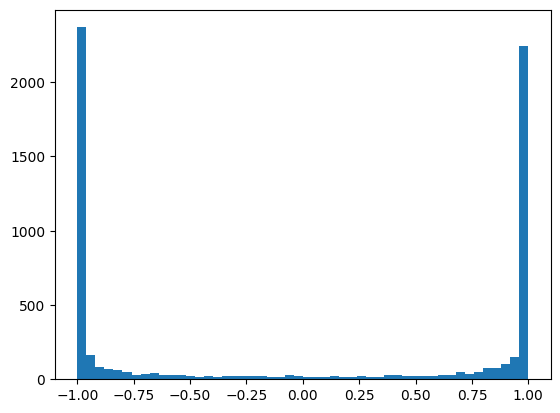

In [15]:
plt.hist(h.view(-1).tolist(),50);

On observe que la majorité des valeurs sont autour de 1 ou -1.

En quoi cela pose-t-il problème ?
Lors du calcul du gradient, avec la règle de la chaîne, on multiplie les gradients des différentes étapes de calcul. La dérivée de la fonction *tanh* est :
$tanh'(t)= 1 - t^2$
Si les valeurs de $t$ sont à 1 ou -1, alors le gradient sera extrêmement faible (jamais nul, car c'est une asymptote). Cela signifie que le gradient ne se propage pas, et donc l'optimisation ne peut pas fonctionner de manière optimale au début de l'entraînement.

On peut visualiser les valeurs de chaque neurone.


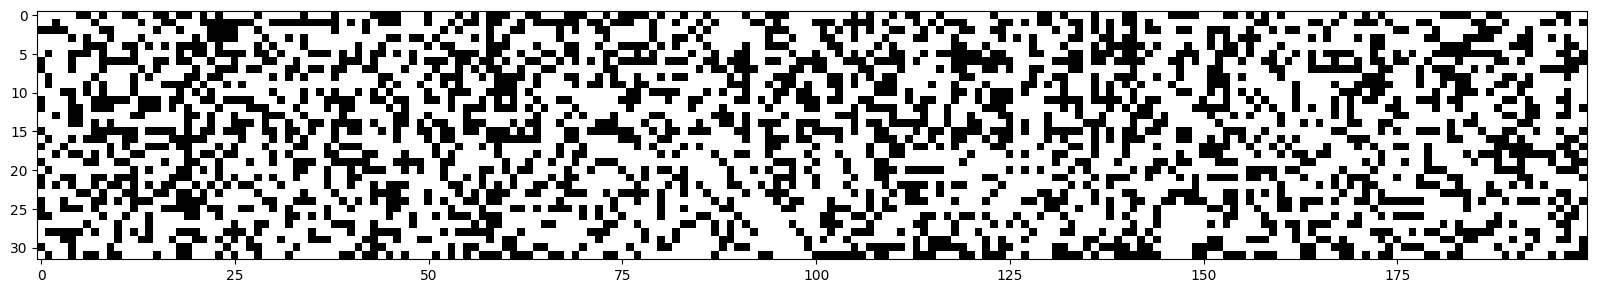

In [16]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

Chaque point blanc correspond à un neurone dont le gradient est à peu près égal à 0.

**Neurone mort** : Si une de ces colonnes était entièrement blanche, cela signifierait que le neurone ne s'active sur aucun élément (du *batch*). Cela signifie qu'il s'agit d'un neurone inutile, qui n'aura aucun impact sur le résultat et qu'on ne peut pas optimiser (sur les valeurs présentes dans ce *batch*).

**Notes** :
- Ce type de comportement n'est pas exclusif à la *tanh* : la *sigmoid* et la *ReLU* peuvent avoir le même problème.
- Le problème ne nous a pas empêché d'entraîner notre réseau correctement, car il s'agit d'un petit modèle. Sur des réseaux plus profonds, c'est un gros problème, et il est conseillé de vérifier les activations de votre réseau aux différentes étapes.
- Les neurones morts peuvent apparaître à l'initialisation, mais aussi pendant l'entraînement si le *learning rate* est trop élevé, par exemple.


### Comment résoudre ce problème ?


Heureusement, ce problème peut se résoudre exactement de la même manière que le problème du *loss* trop élevé. Pour nous en assurer, regardons les valeurs des activations et les neurones inactifs à l'initialisation avec nos nouvelles valeurs.


In [17]:
C = torch.randn((46, embed_dim))
W1 = torch.randn((block_size*embed_dim, hidden_dim)) *0.01# On initialise les poids à une petite valeur
b1 = torch.randn(hidden_dim) *0 # On initialise les biais à 0
W2 = torch.randn((hidden_dim, 46)) *0.01
b2 = torch.randn(46)*0 
parameters = [C, W1, b1, W2, b2]
for p in parameters:
  p.requires_grad = True

In [18]:
ix = torch.randint(0, Xtr.shape[0], (batch_size,))
Xb, Yb = Xtr[ix], Ytr[ix] 
emb = C[Xb] 
embcat = emb.view(emb.shape[0], -1)
hpreact = embcat @ W1 + b1 
h = torch.tanh(hpreact) 
logits = h @ W2 + b2 
loss = F.cross_entropy(logits, Yb)
  
for p in parameters:
  p.grad = None
loss.backward()

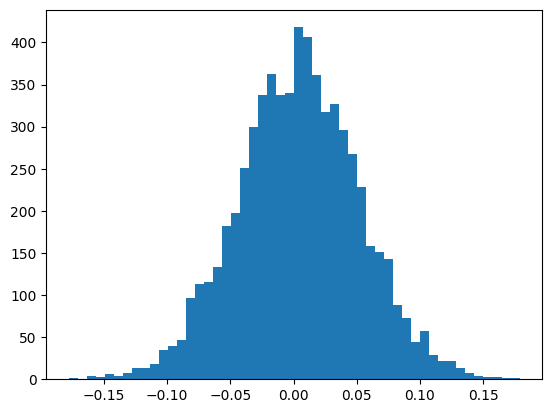

In [19]:
plt.hist(h.view(-1).tolist(),50);

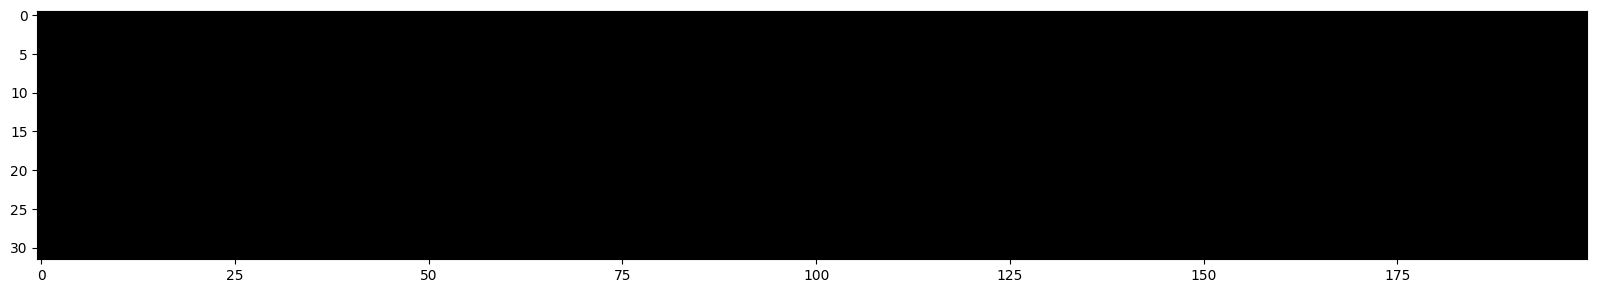

In [20]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>0.99,cmap='gray',interpolation='nearest')

Tout va pour le mieux !


### Valeurs optimales à l'initialisation


Ce problème étant très important, de nombreuses recherches se sont dirigées sur ce sujet. Une publication notable est [Delving Deep into Rectifiers](https://arxiv.org/pdf/1502.01852), qui introduit la *Kaiming initialization*. Le papier propose des valeurs d'initialisation pour chaque fonction d'activation qui garantissent une distribution centrée réduite sur l'ensemble du réseau.

Cette méthode est implémentée en [PyTorch](https://pytorch.org/docs/stable/nn.init.html), et les couches que nous allons créer en PyTorch sont directement initialisées de cette manière.


### Pourquoi ce cours est dans les bonus alors qu'il semble très important ?


Ce problème est en effet un problème majeur. Cependant, lorsque l'on utilise PyTorch, tout est déjà initialisé correctement, et il n'est généralement pas nécessaire de modifier ces valeurs.

De plus, de nombreuses méthodes ont été proposées pour atténuer ce problème, principalement :
- La *batch norm*, que nous verrons dans le notebook suivant, qui consiste à normaliser les valeurs avant l'activation tout au long du réseau.
- Les connexions résiduelles, qui permettent de transmettre le gradient dans l'intégralité du réseau sans que celui-ci ne soit trop impacté par les fonctions d'activation.

Malgré l'importance de ces considérations, en pratique, il n'est pas forcément nécessaire d'être au courant pour entraîner un réseau de neurones.
